In [85]:
import time
import datetime
import json
import os
import random
import numpy as np
import webbrowser
from PIL import Image
import matplotlib.pyplot as plt
from rich.progress import track
import subprocess
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder, DatasetFolder
from torch.utils.data import Dataset
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

In [86]:
transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.Grayscale(),
    transforms.PILToTensor()])

In [87]:
train_dataset = ImageFolder(root="pics_with_coords", transform=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)

In [88]:
class LinNet(nn.Module):
    def __init__(self):
        super(LinNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(64 * 64, 512),
            nn.SiLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        return self.model(x)

In [89]:
data_iter = iter(train_dataloader)
data = next(data_iter)

x, _ = data
x = x.float()


In [90]:
model = LinNet()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
filenames = [train_dataloader.dataset.imgs[i][0].split('/')[-1] for i in range(len(train_dataset))]
len(filenames)

1996

In [91]:
# Initialize scalers once
lat_scaler = MinMaxScaler(feature_range=(-1, 1))
lon_scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit scalers with the full range of possible values
lat_scaler.fit(np.array([[-90], [90]]))
lon_scaler.fit(np.array([[-180], [180]]))

# Test with sample image
img_num = 537

# Extract coordinates from filename
lat = float(train_dataloader.dataset.imgs[img_num][0].strip(".png").split("_")[-2])
lon = float(train_dataloader.dataset.imgs[img_num][0].strip(".png").split("_")[-1])
filename = train_dataloader.dataset.imgs[img_num][0].split('/')[-1]

# Reshape coordinates for scaling
lat = np.array([[lat]])
lon = np.array([[lon]])

# Scale coordinates
scaled_lat = lat_scaler.transform(lat)
scaled_lon = lon_scaler.transform(lon)

# Verify scaling by inverse transform
inv_scaled_lat = lat_scaler.inverse_transform(scaled_lat)
inv_scaled_lon = lon_scaler.inverse_transform(scaled_lon)

# Print results
print(f"Filename: {filename}")
print(f"Original coordinates: lat={lat[0][0]:.6f}, lon={lon[0][0]:.6f}")
print(f"Scaled coordinates: lat={scaled_lat[0][0]:.6f}, lon={scaled_lon[0][0]:.6f}")
print(f"Inverse scaled: lat={inv_scaled_lat[0][0]:.6f}, lon={inv_scaled_lon[0][0]:.6f}")

Filename: epic_RGB_20151002181308_0.358887_-103.747559.png
Original coordinates: lat=0.358887, lon=-103.747559
Scaled coordinates: lat=0.003988, lon=-0.576375
Inverse scaled: lat=0.358887, lon=-103.747559


In [92]:
if os.path.exists('LinNet.pth'):
    try:
        model.load_state_dict(torch.load('LinNet.pth'))
        print("Model loaded!")
    except:
        print("No Model found!")

model = model.to("mps")
loss_list = []
for num, image in enumerate(filenames):
    if num >= 100:
        break
    for param in model.parameters():
                    param.grad = None

    lat = float(train_dataloader.dataset.imgs[num][0].strip(".png").split("_")[-2])
    lon = float(train_dataloader.dataset.imgs[num][0].strip(".png").split("_")[-1])
    lat = np.array([[float(lat)]])
    lon = np.array([[float(lon)]])
    scaled_lat = lat_scaler.transform(lat)
    scaled_lon = lon_scaler.transform(lon)
    # print(lat, scaled_lat)
    # print(lon, scaled_lon)
    target = torch.Tensor([scaled_lat[0], scaled_lon[0]])
    target = target.to("mps")
    img = Image.open(os.path.join('pics_with_coords/all', image))
    img_tensor = transforms(img)
    img_tensor = img_tensor.float()
    img_tensor = img_tensor.view(-1)
    img_tensor = img_tensor.to("mps")

    output = model(img_tensor)
    output = output.view(-1, 1)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    # if num == 20:
            #  break
    
    '''print("Target: ", target)
    output = model(img_tensor)
    output = output.view(-1, 1)
    print("Output:", output)
    # print(img_tensor.size())'''

torch.save(model.state_dict(), 'LinNet.pth')
print(loss.item())

# Best: 0.01068886835128069

Model loaded!
0.01068886835128069


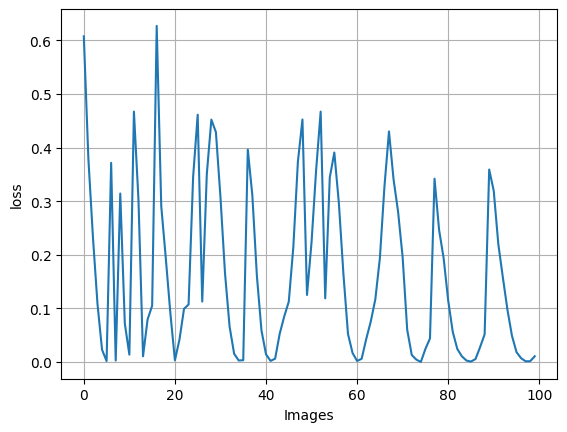

tensor([[0.0677],
        [0.1877]], device='mps:0', grad_fn=<ViewBackward0>)
tensor([[0.0439],
        [0.0435]], device='mps:0')
epic_RGB_20150827123638_3.933105_-8.525391.png


In [93]:

plt.plot(loss_list)
plt.xlabel("Images")
plt.ylabel("loss")
plt.grid()
plt.show()
print(output)
print(target)
print(image)

In [94]:
with torch.no_grad():
    model.eval()

    # Select random picture
    img_num = random.randint(0, len(train_dataloader.dataset)-1)

    # Construct path
    path = train_dataloader.dataset.imgs[img_num][0]
    test_img = Image.open(train_dataloader.dataset.imgs[img_num][0])
    test_img = transforms(test_img)
    test_img = test_img.float()
    test_img = test_img.view(-1)
    test_img = test_img.to("mps")

    output = model(test_img)
    
    # Get original coordinates
    lat = float(train_dataloader.dataset.imgs[img_num][0].strip(".png").split("_")[-2])
    lon = float(train_dataloader.dataset.imgs[img_num][0].strip(".png").split("_")[-1])
    filename = train_dataloader.dataset.imgs[img_num][0].split('/')[-1]

    # Get model predictions
    output = output.to("cpu").detach().numpy()
    
    # Reshape output to match scaler input shape
    pred_lat = output[0].reshape(-1, 1)
    pred_lon = output[1].reshape(-1, 1)

    # Transform back to original coordinates
    pred_lat = lat_scaler.inverse_transform(pred_lat)
    pred_lon = lon_scaler.inverse_transform(pred_lon)

    print(f"Predicted coordinates: lat={pred_lat[0][0]:.6f}, lon={pred_lon[0][0]:.6f}")
    print(f"Actual coordinates: lat={lat:.6f}, lon={lon:.6f}")
    print(f"Error: lat={abs(pred_lat[0][0]-lat):.6f}, lon={abs(pred_lon[0][0]-lon):.6f}")
    print(f"Image: {filename}")

    


Predicted coordinates: lat=-9.413985, lon=6.917823
Actual coordinates: lat=-1.757812, lon=23.576660
Error: lat=7.656173, lon=16.658837
Image: epic_RGB_20151016093858_-1.757812_23.57666.png


In [95]:
# set up orthographic map projection with
# perspective of satellite looking down at 45N, 100W.
# use low resolution coastlines.
map = Basemap(projection='ortho',lat_0=lat[0][0],lon_0=lon[0][0],resolution='l')
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='coral',lake_color='aqua')
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='aqua')
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

x, y = map(lon, lat)
map.scatter(x, y)
plt.title('contour lines over filled continent background')
plt.show()



TypeError: 'float' object is not subscriptable